#### This notebook demonstrates the use of the learning fair representations algorithm for bias mitigation
Learning fair representations [1] is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes. We will see how to use this algorithm for learning representations that encourage individual fairness and apply them on the Adult dataset.

References:

[1] R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork,  "Learning Fair Representations." 
International Conference on Machine Learning, 2013.

In [1]:
# load variables from computing environment
import sys
sys.path.append("/home/jl0274/AIF360/aif360/algorithms/inprocessing/")
# import dill
# dill.load_session('log_reg_lfr_env.db')

In [2]:
# # save variables to computing environment

# import dill
# dill.dump_session('log_reg_lfr_env.db')

In [3]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

from common_utils import compute_metrics

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [4]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

In [5]:
import pandas as pd
print(pd.__version__)

2.2.3


In [6]:
import pandas as pd
X_train = pd.read_pickle('/home/jl0274/Senior Thesis/X_train_norm.pkl')
y_train = pd.read_pickle('/home/jl0274/Senior Thesis/y_train.pkl')
X_val = pd.read_pickle('/home/jl0274/Senior Thesis/X_val_norm.pkl')
y_val = pd.read_pickle('/home/jl0274/Senior Thesis/y_val.pkl')
X_test = pd.read_pickle('/home/jl0274/Senior Thesis/X_test_norm.pkl')
y_test = pd.read_pickle('/home/jl0274/Senior Thesis/y_test.pkl')
print(X_train.isna().any().any())
print(y_train.isna().any().any())
print(X_val.isna().any().any())
print(y_val.isna().any().any())
print(X_test.isna().any().any())
print(y_test.isna().any().any())

False
False
False
False
False
False


#### Load dataset and set options

In [7]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_adult(["sex"])
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

standard dataset: is na? False


#### Clean up training data

In [8]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for original training data

In [9]:
# Metric for the original dataset
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053669


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.051374


#### Train with and transform the original training data

In [10]:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
    
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

step: 0, loss: 0.986282800990282, L_x: 0.426390428807253,  L_y: 0.9165256631090605,  L_z: 0.013559047500248111
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          220     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86283D-01    |proj g|=  2.79213D-01
step: 250, loss: 0.7131559740822846, L_x: 0.42430827072643096,  L_y: 0.6442263626211242,  L_z: 0.013249392194258636

At iterate    1    f=  7.13156D-01    |proj g|=  1.40648D-01
step: 500, loss: 0.6121522899190296, L_x: 0.41761138585916524,  L_y: 0.5454013417384268,  L_z: 0.012494904797343127

At iterate    2    f=  6.12152D-01    |proj g|=  7.64064D-02
step: 750, loss: 0.581516636034133, L_x: 0.40724710774945017,  L_y: 0.5181425646904099,  L_z: 0.011324680284389033

At iterate    3    f=  5.81517D-01    |proj g|=  3.04683D-02
step: 1000, loss: 0.5686966991455905, L_x: 0.3980909867217147,  L_y: 0.5083617800953724,  L_z: 0.010262910189023313

At iterate

In [11]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

In [12]:
print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     86556
         1.0       1.00      0.91      0.95    267893

    accuracy                           0.93    354449
   macro avg       0.89      0.96      0.92    354449
weighted avg       0.95      0.93      0.94    354449



In [13]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.027921


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.026277


In [14]:
from common_utils import compute_metrics

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
eq_opp_diff_arr_transf = []
theil_arr_transf = []
f1_arr = []
roc_arr = []

class_thresh_arr = np.linspace(0.01, 0.99, 100)

dataset_transf_test_new = dataset_orig_test.copy(deepcopy=True)
dataset_transf_test_new.scores = dataset_transf_test.scores


for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_new.scores > thresh
    dataset_transf_test_new.labels[fav_inds] = 1.0
    dataset_transf_test_new.labels[~fav_inds] = 0.0
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_new, 
                                      unprivileged_groups, privileged_groups,
                                      disp = False)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    eq_opp_diff_arr_transf.append(metric_test_aft["Equal opportunity difference"])
    theil_arr_transf.append(metric_test_aft["Theil index"])
    f1_arr.append(f1_score(dataset_orig_test.labels, dataset_transf_test_new.labels))
    roc_arr.append(roc_auc_score(dataset_orig_test.labels, dataset_transf_test_new.scores))

#### Predictions from transformed testing data

 92%|█████████▏| 92/100 [00:11<00:00,  8.04it/s]/home/jl0274/AIF360/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


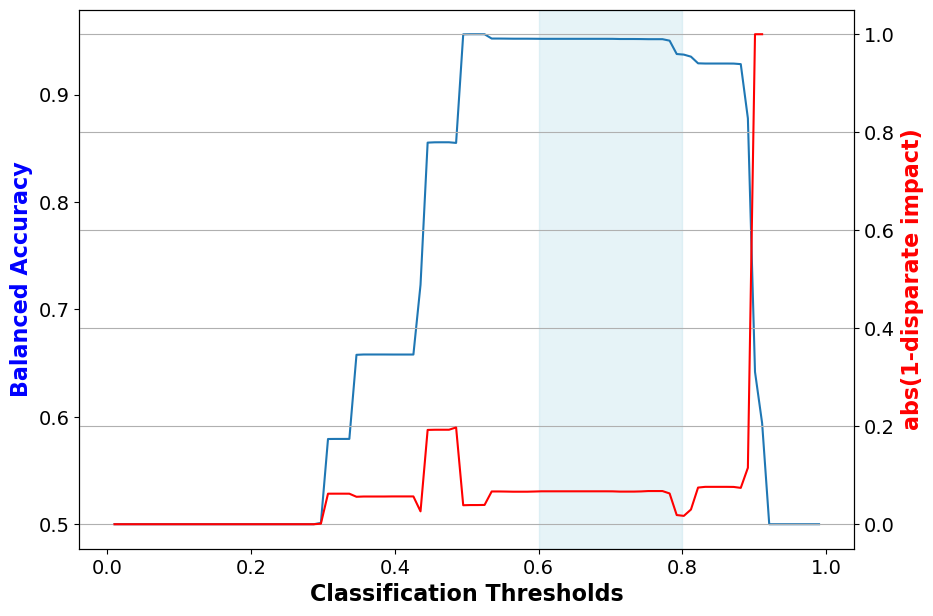

In [15]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-di")

plt.show()

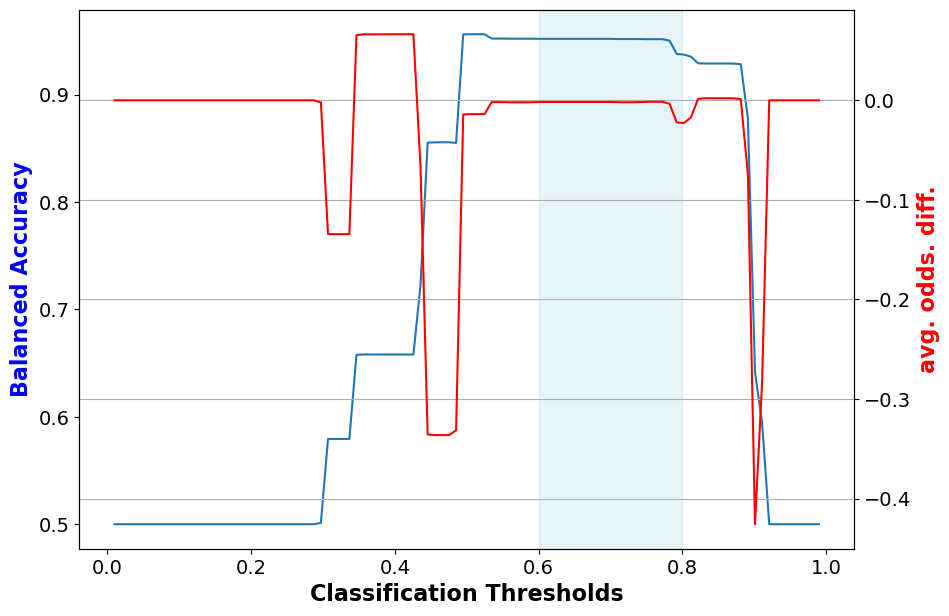

In [16]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds. diff.', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-aodds")

plt.show()

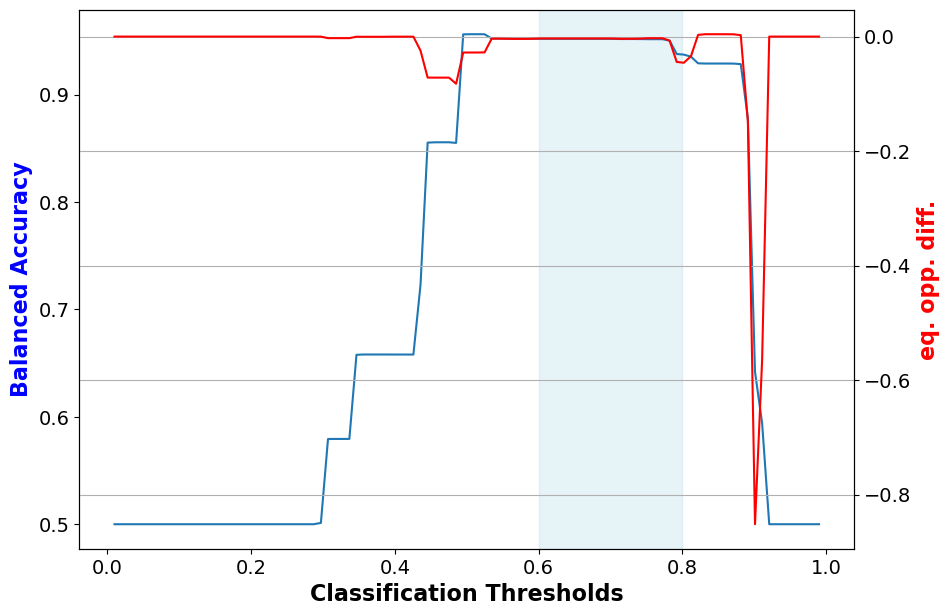

In [17]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, eq_opp_diff_arr_transf, color='r')
ax2.set_ylabel('eq. opp. diff.', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-eqopp")

plt.show()

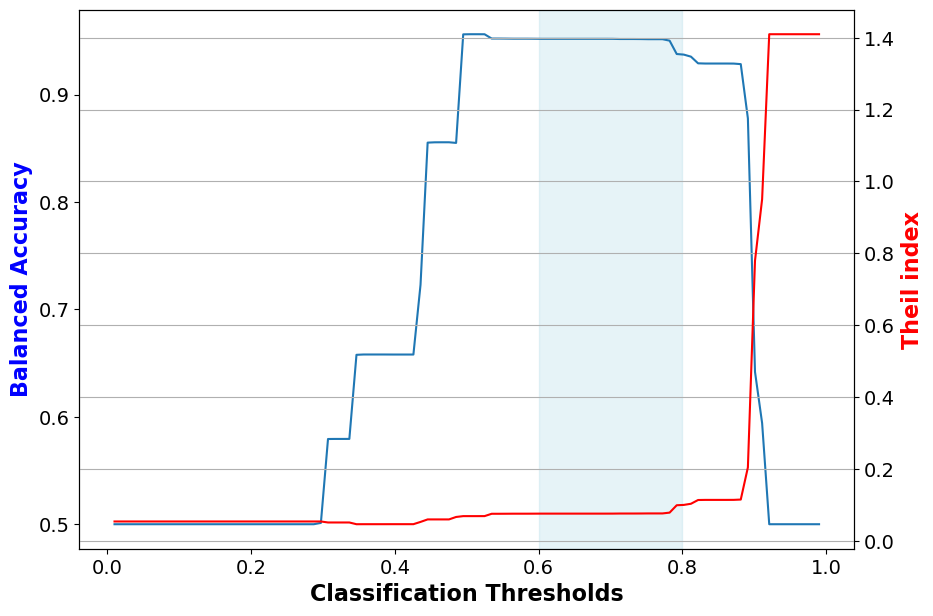

In [18]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, theil_arr_transf, color='r')
ax2.set_ylabel('Theil index', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-theil")

plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, f1_arr, color='r')
ax2.set_ylabel('F1 score', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-f1")

plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax1.axvspan(0.6, 0.8, color='lightblue', alpha=0.3)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, roc_arr, color='r')
ax2.set_ylabel('ROC-AUC score', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("lfr-roc")

plt.show()

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.